# Beyond Language Models: Byte Models are Digital World Simulators

Wu, Shangda, Xu Tan, Zili Wang, Rui Wang, Xiaobing Li, and Maosong Sun. “Beyond Language Models: Byte Models Are Digital World Simulators.” arXiv:2402.19155. Preprint, arXiv, February 29, 2024. https://doi.org/10.48550/arXiv.2402.19155.


In [ ]:
# !pip install fsspec==2023.9.2
# !pip install samplings

In [3]:
import os
import math
import random
import pathlib
from dataclasses import dataclass

from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import get_scheduler
from datasets import load_dataset

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import GradScaler, autocast

import torchvision
from torchvision import transforms
from torchvision.transforms import ToPILImage

from samplings import top_p_sampling, top_k_sampling, temperature_sampling

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.manual_seed(42)

In [484]:
PATCH_SIZE          = 16                # S
PATCH_LENGTH        = 1024
PATCH_NUM_LAYERS    = 3                 # number of layers in the encoder
HIDDEN_SIZE         = 384               # H, embed_dim
N_HEADS             = HIDDEN_SIZE // 64
DROPOUT             = 0.1
QKV_BIAS            = False

VOCAB_SIZE          = 256 + 1           # 256 + <eop> token, V
SPECIAL_TOKEN_ID    = 256
LAYER_NORM_EPSILON  = 1e-5

NUM_EPOCHS = 10
BATCH_SIZE = 8
LEARNING_RATE = 1e-5
TOP_K = 3
TOP_P = 0.99
TEMPERATURE = 1

INPUT_FILENAME = "input.txt"
OUTPUT_FILENAME = "generation.txt"

## Dataset

In [202]:
def list_files_in_directory(directory):
    file_list = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            file_list.append(file_path)
    return file_list

In [389]:
def read_bytes(filename):

    ext = filename.split('.')[-1]
    ext = bytearray(ext, 'utf-8')
    ext = [byte for byte in ext][:PATCH_SIZE]

    with open(filename, 'rb') as f:
        file_bytes = f.read()

    bytes = []
    for byte in file_bytes:
        bytes.append(byte)

    if len(bytes)%PATCH_SIZE!=0:
        bytes = bytes + [256] * (PATCH_SIZE - len(bytes) % PATCH_SIZE)

    bos_patch = ext + [256] * (PATCH_SIZE - len(ext))
    bytes = bos_patch + bytes + [256] * PATCH_SIZE

    if len(bytes) > PATCH_LENGTH*PATCH_SIZE:
        choices = ["head", "body", "tail"]
        choice = random.choice(choices)
        if choice == "head":
            bytes = bytes[:PATCH_LENGTH*PATCH_SIZE]
        elif choice == "body" and len(bytes) > (PATCH_LENGTH+1)*PATCH_SIZE:
            start = random.randint(1, len(bytes)//PATCH_SIZE-PATCH_LENGTH)
            bytes = bytes[start*PATCH_SIZE:(start+PATCH_LENGTH)*PATCH_SIZE]
        else:
            bytes = bytes[-PATCH_LENGTH*PATCH_SIZE:]

    masks = [1] * (len(bytes)//PATCH_SIZE)

    return bytes, masks

### Text dataset

In [ ]:
dataset = load_dataset("wikimedia/wikipedia", "20231101.hu", split="train[:10%]", cache_dir="/content/hf_cache")

In [205]:
dataset = dataset.train_test_split(test_size=0.1, seed=42)

In [206]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'url', 'title', 'text'],
        num_rows: 47918
    })
    test: Dataset({
        features: ['id', 'url', 'title', 'text'],
        num_rows: 5325
    })
})

In [496]:
TRAIN_FOLDERS = "wikipedia/train"
EVAL_FOLDERS = "wikipedia/test"

os.makedirs(TRAIN_FOLDERS, exist_ok=True)
os.makedirs(EVAL_FOLDERS, exist_ok=True)

In [497]:
for i in range(len(dataset["train"])):
    text = dataset["train"][i]["text"]
    with open(f"{TRAIN_FOLDERS}/text_{i}.txt", "w") as f:
        f.write(text)

In [498]:
for i in range(len(dataset["test"])):
    text = dataset["test"][i]["text"]
    with open(f"{EVAL_FOLDERS}/text_{i}.txt", "w") as f:
        f.write(text)

In [499]:
train_files = list_files_in_directory(TRAIN_FOLDERS)
test_files = list_files_in_directory(EVAL_FOLDERS)

In [500]:
assert len(train_files) == len(dataset["train"]), f"{len(train_files)} != {len(dataset['train'])}"
assert len(test_files) == len(dataset["test"]), f"{len(test_files)} != {len(dataset['test'])}"

In [501]:
class ByteDataset(Dataset):
    def __init__(self, filenames, split='train'):
        print(f"Autoregressive Training Mode: loading {len(filenames)} files for {split}")
        self.filenames = filenames

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        file_bytes, file_masks = read_bytes(filename)
        file_bytes = torch.tensor(file_bytes, dtype=torch.long)
        file_masks = torch.tensor(file_masks, dtype=torch.long)
        return file_bytes, file_masks

In [502]:
train_set = ByteDataset(train_files, split='train')
test_set = ByteDataset(test_files, split='test')

Autoregressive Training Mode: loading 47918 files for train
Autoregressive Training Mode: loading 5325 files for test


In [503]:
def collate_batch(input_batches):
    input_patches, input_masks = zip(*input_batches)
    input_patches = torch.nn.utils.rnn.pad_sequence(input_patches, batch_first=True, padding_value=256)
    input_masks = torch.nn.utils.rnn.pad_sequence(input_masks, batch_first=True, padding_value=0)
    return input_patches.to(device), input_masks.to(device)

In [504]:
train_set = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle=True, num_workers=0)
test_set = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle=False, num_workers=0)

### Image Dataset

In [449]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [450]:
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

In [451]:
class_names = train_data.classes
class_dict = train_data.class_to_idx
print(class_dict)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [473]:
TRAIN_FOLDERS = "cifar100/train"
EVAL_FOLDERS = "cifar100/test"

os.makedirs(TRAIN_FOLDERS, exist_ok=True)
os.makedirs(EVAL_FOLDERS, exist_ok=True)

In [453]:
for i in range(len(train_data)):
    img_tensor, label = train_data[i]
    img = transforms.ToPILImage()(img_tensor) # PIL auto converts to 8-bit per channel
    img.save(f"cifar100/train/image_{i}_label_{label}.bmp", format="BMP")

for i in range(len(test_data)):
    img_tensor, label = test_data[i]
    img = transforms.ToPILImage()(img_tensor) # PIL auto converts to 8-bit per channel
    img.save(f"cifar100/test/image_{i}_label_{label}.bmp", format="BMP")

In [474]:
train_files = list_files_in_directory(TRAIN_FOLDERS)
test_files = list_files_in_directory(EVAL_FOLDERS)

In [475]:
class ByteDataset(Dataset):
    def __init__(self, filenames, split='train'):
        print(f"Classification Mode: Loading {len(filenames)} files for {split}")
        self.filenames = []
        self.labels = {}

        for filename in tqdm(filenames):
            file_size = os.path.getsize(filename)
            file_size = math.ceil(file_size / PATCH_SIZE)
            ext = filename.split('.')[-1]
            label = os.path.basename(filename).split('_label_')[1]
            label = label.replace(".bmp", "")

            self.filenames.append((filename, label))
            #if label not in self.labels:
            #    self.labels[label] = len(self.labels)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):

        filename, label = self.filenames[idx]
        file_bytes, file_masks = read_bytes(filename)

        file_bytes = torch.tensor(file_bytes, dtype=torch.long)
        label = torch.tensor(int(label), dtype=torch.long)

        return file_bytes, label

In [476]:
train_set = ByteDataset(train_files, split='train')
test_set = ByteDataset(test_files, split='test')

Classification Mode: Loading 50000 files for train


100%|██████████| 50000/50000 [00:00<00:00, 235893.21it/s]


Classification Mode: Loading 10000 files for test


100%|██████████| 10000/10000 [00:00<00:00, 236253.56it/s]


In [477]:
def collate_batch(input_patches):

    input_patches, labels = zip(*input_patches)
    input_patches = torch.nn.utils.rnn.pad_sequence(input_patches, batch_first=True, padding_value=256)
    labels = torch.stack(labels, dim=0)

    return input_patches.to(device), labels.to(device)

In [478]:
train_set = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle=True, num_workers=0)
test_set = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle=False, num_workers=0)

## bGPT

### Linear Projection Layer

In [226]:
class LinearProjectionLayer(nn.Module):
    def __init__(self):
        super().__init__()

        self.w_linear = nn.Linear(PATCH_SIZE * VOCAB_SIZE, HIDDEN_SIZE, bias=False)

    def forward(self, patches):                                                   # (P, 1, S)
        patches = torch.nn.functional.one_hot(patches, num_classes=VOCAB_SIZE)     # (P, 1, S, V)
        patches = torch.flatten(patches, start_dim=2)                               # (P, 1, S x V)
        embed = self.w_linear(patches.float())                                      # (P, 1, H)
        return embed

In [227]:
# lpl = LinearProjectionLayer().to(device)

### Patch-Level Decoder

In [228]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.c_fc = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE * 4)
        self.c_proj = nn.Linear(HIDDEN_SIZE * 4, HIDDEN_SIZE)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.act(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

In [229]:
def create_causal_mask(t: int, device=None):
    return torch.triu(torch.ones(t, t, device=device), diagonal=1).bool()

In [230]:
class MultiQueryAttention(nn.Module):

    def __init__(self, d_model: int, h: int):
        super().__init__()

        assert d_model % h == 0, "d_model is indivisible by h (number of heads)"

        self.d_model = d_model
        self.h = h
        self.d_k = self.d_v = d_model // h

        self.q_proj = nn.Linear(d_model, h * self.d_k)
        self.k_proj = nn.Linear(d_model, self.d_k)
        self.v_proj = nn.Linear(d_model, self.d_v)

        self.out_proj = nn.Linear(h * self.d_v, d_model)

    def forward(self, x: torch.Tensor):

        b, t, d_model = x.shape

        q = self.q_proj(x).view(b, self.h, t, self.d_k)
        k = self.k_proj(x).view(b, 1, t, self.d_k)
        v = self.v_proj(x).view(b, 1, t, self.d_v)

        k = k.repeat_interleave(self.h, dim=1)
        v = v.repeat_interleave(self.h, dim=1)

        # (b, h, t, t) = (b, h, t, d_k) @ (b, h, d_k, t)
        attn_scores = torch.matmul(q, k.transpose(2, 3))

        attn_mask = create_causal_mask(t, x.device) # (t, t)
        # casual attention (set all true positions to -inf)
        attn_scores.masked_fill_(attn_mask, -torch.inf)

        attn_weights = torch.softmax(attn_scores / math.sqrt(self.d_k), dim=-1)

        # (b, h, t, d_v) = (b, h, t, t) @ (b, h, t, d_v)
        # (b, t, h, d_v) <- (b, h, t, d_v)
        context = torch.matmul(attn_weights, v).transpose(1, 2).contiguous()

        context = context.view(b, t, self.d_model)

        return self.out_proj(context)

In [231]:
class DecoderBlock(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_norm1 = nn.LayerNorm(HIDDEN_SIZE)
        self.masked_mqa = MultiQueryAttention(HIDDEN_SIZE, N_HEADS)
        self.layer_norm2 = nn.LayerNorm(HIDDEN_SIZE)

        self.mlp = MLP()

        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, x, ):

        residual = x
        x = self.layer_norm1(x)
        x = self.masked_mqa(x)
        x = x + residual

        residual = x
        x = self.layer_norm2(x)
        x = self.mlp(x)
        x = x + residual

        return x

In [232]:
class PatchLevelDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.patch_embedding = LinearProjectionLayer()
        self.wpe = nn.Embedding(PATCH_LENGTH, HIDDEN_SIZE) # positional embedding

        self.drop = nn.Dropout(DROPOUT)

        self.layers = nn.ModuleList([DecoderBlock() for i in range(PATCH_NUM_LAYERS)])
        self.layer_norm = nn.LayerNorm(HIDDEN_SIZE, eps = LAYER_NORM_EPSILON)

    def forward(self, patches): # (B, S)

        patch_embeds = self.patch_embedding(patches) # (B, P, H)

        # add positional embeddigns, [0, 1, ..., P_n]
        input_shape = patch_embeds.size()[:-1] # P_n
        position_ids = torch.arange(0, input_shape[-1], dtype=torch.long, device=device)

        position_embeds = self.wpe(position_ids)
        hidden_states = patch_embeds + position_embeds
        hidden_states = self.drop(hidden_states) # (B, P, H)

        for layer in self.layers:
            hidden_states = layer(hidden_states)
        hidden_states = self.layer_norm(hidden_states)

        return hidden_states # (B, P, H)

### Byte-Level Decoder

In [233]:
class ByteLevelDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.wte = nn.Embedding(VOCAB_SIZE, HIDDEN_SIZE)
        self.wpe = nn.Embedding(PATCH_SIZE + 1, HIDDEN_SIZE)

        self.drop = nn.Dropout(DROPOUT)

        self.layers = nn.ModuleList([DecoderBlock() for i in range(PATCH_NUM_LAYERS)])
        self.layer_norm = nn.LayerNorm(HIDDEN_SIZE, eps=LAYER_NORM_EPSILON)

        self.lm_head = nn.Linear(HIDDEN_SIZE, VOCAB_SIZE, bias=False)

    def forward(self, encoded_patches, target_patches): # (N, H), (N, S)

        # prepend <eop> special token to patch, (P, 1+S)
        target_patches = torch.cat(
            (torch.ones_like(target_patches[:,0:1]) * SPECIAL_TOKEN_ID, target_patches), dim=1
        )
        inputs_embeds = self.wte(target_patches)

        # (N, 1+S, H) <- concatenate[(N, 1, H), (N, 1+S, H)] <- concatenate[(N, H), (N, 1+S, H)]
        # where N = (B x P) - invalid patches
        inputs_embeds = torch.cat((encoded_patches.unsqueeze(1), inputs_embeds[:,1:,:]), dim=1)

        # positional embeddings [0, 1, ..., S]
        input_shape = inputs_embeds.size()[:-1] # S
        position_ids = torch.arange(0, input_shape[-1], dtype=torch.long, device=device)
        position_embeds = self.wpe(position_ids) # (S+1, H)

        hidden_states = inputs_embeds + position_embeds # (P, 1+S, H)
        hidden_states = self.drop(hidden_states) # (P, 1+S, H)

        for layer in self.layers:
            hidden_states = layer(hidden_states)
        hidden_states = self.layer_norm(hidden_states)
        logits = self.lm_head(hidden_states)
        return logits, target_patches

    def generate(self, encoded_patches, tokens):

        # decoder is independent for each patch -> only need last patch
        encoded_patch = encoded_patches[0][-1] # (H)

        # encoded_patch = encoded_patch.reshape(1, 1, -1) # (1,1, H)
        encoded_patch = encoded_patch.reshape(1, -1) # (1, H)
        tokens = tokens.reshape(1, -1) # (1, S)

        logits, _ = self.forward(encoded_patch, tokens)
        logit = logits.squeeze(0)[-1] # next token
        # probs = torch.nn.functional.softmax(logit, dim=-1).cpu().detach().numpy()
        probs = torch.nn.functional.softmax(logit, dim=-1)
        return probs

## Language Model

In [445]:
class bGPT(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear_proj = LinearProjectionLayer()
        self.patch_level_decoder = PatchLevelDecoder()
        self.byte_level_decoder = ByteLevelDecoder()

    def forward(self, patches, masks): # (B, T), (B, P), T = tokens

        patches = patches.reshape(len(patches), -1, PATCH_SIZE) # (B, P, S)
        encoded_patches = self.patch_level_decoder(patches) # (B, P, H)

        # [[1,1,1, ..., 1,0,0,0], ...] <- [[1,1,1, ..., 1,1,0,0], ...]
        left_shift_masks = masks * (masks.flip(1).cumsum(1).flip(1) > 1)
        masks[:, 0] = 0 # [[0,1,1, ..., 1,0,0], ...] <- [[1,1,1, ..., 1,0,0], ...]

        encoded_patches = encoded_patches[left_shift_masks == 1] # (N, H) = ((B x P) - invalid patches, H)
        patches = patches[masks == 1] # (N, S) = ((B x P) - invalid patches, S)

        assert encoded_patches.shape[0] == patches.shape[0], f"{encoded_patches.shape} != {patches.shape}"

        logits, labels = self.byte_level_decoder(encoded_patches, patches) # (N, 1+S, V)
        return logits, labels

    def generate(self, patches, masks): # (B, T), (B, P)

        patches = patches.unsqueeze(1) # (B, 1, T)

        if patches.shape[-1] % PATCH_SIZE != 0:
            tokens = patches[:,:,-(patches.shape[-1]%PATCH_SIZE):].squeeze(0).squeeze(0)
            patches = patches[:,:,:-(patches.shape[-1]%PATCH_SIZE)]
        else:
            tokens = torch.tensor([], device=device)

        patches = patches.reshape(len(patches), -1, PATCH_SIZE) # (B, P, S)

        encoded_patches = model.patch_level_decoder(patches) # (B, P, H)

        generated_patch = []

        while True:

            probs = model.byte_level_decoder.generate(encoded_patches, tokens) # (H), (1, S)

            probs = top_k_sampling(probs)
            probs = top_p_sampling(probs)
            token = temperature_sampling(probs, temperature=TEMPERATURE)

            generated_patch.append(token)

            if token == SPECIAL_TOKEN_ID or len(tokens) >= PATCH_SIZE:
                break
            else:
                tokens = torch.cat((tokens, torch.tensor([token], device=device)), dim=0)

        return generated_patch

In [269]:
model = bGPT().to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: {params / 1e6:.2f} M")

Model parameters: 12.93 M


## Generation

In [430]:
str_to_byte = lambda s: list(s.encode('utf-8'))
byte_to_str = lambda b: bytes(b).decode('utf-8', errors='ignore')
create_mask = lambda bytes_list: [1] * (len(bytes_list)//PATCH_SIZE)

In [440]:
def generate(text_bytes: str, top_k=0, top_p=1, temperature=1.0, return_full_text = True):
    text_bytes = str_to_byte(text_bytes)
    prefix_len = len(text_bytes)

    masks = create_mask(text_bytes)
    masks = torch.tensor(masks, device=device) # (P)

    input_patches = torch.tensor([text_bytes], device=device) # (1, ...), batch size=1

    while input_patches.shape[1] < PATCH_LENGTH * PATCH_SIZE:

        predicted_patch = model.generate(input_patches, masks) # (1, P)

        for byte in predicted_patch:
            if byte == 256:
                break
            text_bytes.append(byte)
        if byte == 256:
            break

        predicted_patch = torch.tensor([predicted_patch], device=device)
        input_patches = torch.cat([input_patches, predicted_patch], dim=1)

    if not return_full_text:
        text_bytes = text_bytes[prefix_len:]
    with open(OUTPUT_FILENAME, 'wb') as file:
        for byte in text_bytes:
            file.write(bytes([byte]))
    return byte_to_str(text_bytes)

In [446]:
def top_k_sampling(probs, top_k = 10): # (V)
    # get k largest element from logit with indices
    top_probs, top_pos = torch.topk(probs, top_k)
    # select top k possible tokens, assign -inf to all others in batch
    probs = torch.where(
        condition=probs < top_probs[-1],
        input=torch.tensor(0, device=probs.device),
        other=probs
    )
    # renormalize remaining probabilities
    probs = probs / probs.sum(dim=-1, keepdim=True)
    return probs

def top_p_sampling(probs, top_p = 0.95): # (V)
    # sort probabilities in descending order
    probs_sort, probs_idx = torch.sort(probs, dim=-1, descending=True)
    # create cumulative sum of elements
    cumulative_probs = torch.cumsum(probs_sort, dim=-1)
    # mark tokens having values over top_p
    cutoff_idx = torch.sum(cumulative_probs <= top_p, dim=-1)
    probs_sort[cutoff_idx+1:] = 0.0
    # renormalize remaining probabilities
    probs_sort = probs_sort / probs_sort.sum(dim=-1, keepdim=True)
    # map back to original positions
    probs = torch.gather(probs_sort, 0, probs_idx.argsort(-1))
    return probs

def temperature_sampling(probs, temperature = 1.0) -> torch.Tensor: # (V)
    probs = torch.softmax(probs / temperature, dim=-1)
    # get the idx of the vocab entry by multinomial sampling
    idx_next = torch.multinomial(probs, num_samples=1)
    return idx_next

In [447]:
example = "How can the net amount of entropy of the universe be massively decreased?"

In [ ]:
generate(example, return_full_text=False)

## Language Model Training

In [279]:
scaler = GradScaler()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = get_scheduler(
    name="cosine",
    optimizer=optimizer,
    num_warmup_steps=NUM_EPOCHS * len(train_set) // 10,
    num_training_steps=NUM_EPOCHS * len(train_set),
)

In [281]:
def process_one_batch(batch):

    input_patches, input_masks = batch                              # (B, P x S), (B, P)

    logits, labels = model(input_patches, input_masks)              # (N, S+1, V), (N, S)

    # drop last time step (can’t predict next token)
    shift_logits = logits[..., :-1, :]                              # (N, S, V)

    # drop first token (don’t predict <eop> token)
    shift_labels = labels[..., 1:].contiguous()                     # (N, S)

    # flattened logits and labels for loss
    shift_logits = shift_logits.reshape(-1, shift_logits.size(-1))  # (N x S, V)
    shift_labels = shift_labels.view(-1)                            # (N x S)

    loss = loss_fn(shift_logits, shift_labels)
    return loss

In [301]:
def train_epoch():

    tqdm_train_set = tqdm(train_set)
    total_train_loss = 0
    iter_idx = 1
    model.train()

    train_steps = (NUM_EPOCHS-1) * len(train_set)

    for batch in tqdm_train_set:

        with autocast(device_type="cuda"):
            loss = process_one_batch(batch)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        lr_scheduler.step()
        model.zero_grad(set_to_none=True)

        total_train_loss += loss.item()
        tqdm_train_set.set_postfix({'train_loss': total_train_loss / iter_idx})
        train_steps += 1
        iter_idx += 1
    return total_train_loss / iter_idx

In [302]:
def eval_epoch():
    tqdm_eval_set = tqdm(test_set)
    total_eval_loss = 0
    iter_idx = 1
    model.eval()
    for batch in tqdm_eval_set:
        with torch.no_grad():
            loss = process_one_batch(batch)
            total_eval_loss += loss.item()
        tqdm_eval_set.set_postfix({ 'eval_loss': total_eval_loss / iter_idx })
        iter_idx += 1
    return total_eval_loss / iter_idx

In [293]:
train_losses, eval_losses = [], []

In [390]:
for epoch in range(1, NUM_EPOCHS+1):
    print('-' * 21 + "Epoch " + str(epoch) + '-' * 21)
    train_loss = train_epoch()
    eval_loss = eval_epoch()
    train_losses.append(train_loss)
    eval_losses.append(eval_loss)

---------------------Epoch 1---------------------


100%|██████████| 1250/1250 [00:37<00:00, 33.20it/s, eval_loss=0.541]


---------------------Epoch 2---------------------


100%|██████████| 1250/1250 [00:37<00:00, 33.44it/s, eval_loss=0.43]


---------------------Epoch 3---------------------


100%|██████████| 1250/1250 [00:37<00:00, 33.48it/s, eval_loss=0.294]


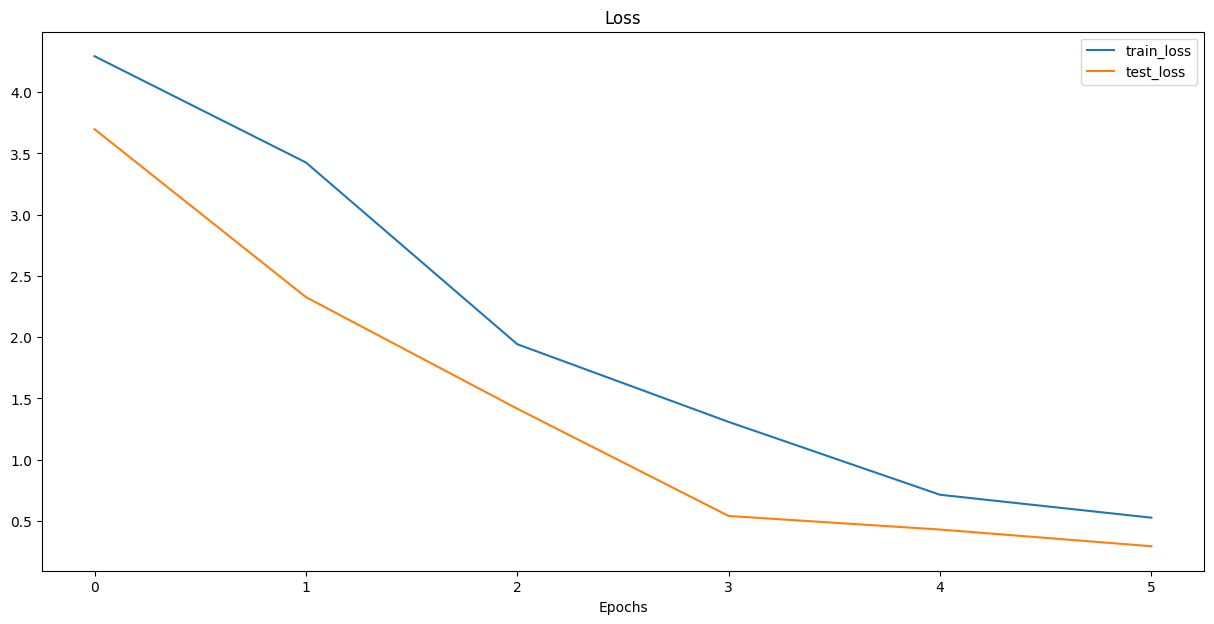

In [393]:
plt.figure(figsize=(15, 7))

epochs = range(NUM_EPOCHS)

plt.plot(epochs, train_losses, label="train_loss")
plt.plot(epochs, eval_losses, label="test_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

## Classification Model

In [461]:
LABELS_SIZE = len(train_data.classes)

In [462]:
class bGPTForClassification(nn.Module):
    def __init__(self):
        super().__init__()

        self.patch_level_decoder = PatchLevelDecoder()
        self.classifier = torch.nn.Linear(HIDDEN_SIZE, LABELS_SIZE)

        torch.nn.init.normal_(self.classifier.weight, std=0.02)

    def forward(self, patches: torch.Tensor):  # (B, S)
        patches = patches.reshape(len(patches), -1, PATCH_SIZE) # (B, P, S)
        encoded_patches = self.patch_level_decoder(patches) # (B, P, H)
        # average pooling, calculate average embedding across all patches in batch
        encoded_patches = torch.mean(encoded_patches, dim=1) # (B, H)
        return self.classifier(encoded_patches) # (B, LABELS)

In [463]:
model = bGPTForClassification().to(device)

In [464]:
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6:.2f} M")

Model parameters: 6.56 M


## Classification Training

In [485]:
scaler = GradScaler()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.CrossEntropyLoss()

lr_scheduler = get_scheduler(
    name="cosine",
    optimizer=optimizer,
    num_warmup_steps=NUM_EPOCHS * len(train_set) // 10,
    num_training_steps=NUM_EPOCHS * len(train_set),
)

In [486]:
def process_one_batch(batch):
    input_patches, labels = batch
    logits = model(input_patches)
    loss = loss_fn(logits, labels)
    prediction = torch.argmax(logits, dim=1)
    acc_num = torch.sum(prediction == labels)
    return loss, acc_num

In [487]:
def train_epoch():

    tqdm_train_set = tqdm(train_set)
    total_train_loss = 0
    total_acc_num = 0
    iter_idx = 1
    model.train()

    train_steps = (NUM_EPOCHS-1) * len(train_set)

    for batch in tqdm_train_set:
        with autocast(device_type="cuda"):
            loss, acc_num = process_one_batch(batch)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        lr_scheduler.step()
        model.zero_grad(set_to_none=True)

        total_train_loss += loss.item()
        total_acc_num += acc_num.item()

        tqdm_train_set.set_postfix({
            'train_loss': total_train_loss / iter_idx,
            'train_acc': total_acc_num / (iter_idx * BATCH_SIZE)
        })

        train_steps += 1
        iter_idx += 1

    acc = total_acc_num / ( (iter_idx-1) * BATCH_SIZE )
    loss = total_train_loss / iter_idx
    return acc, loss

In [488]:
def eval_epoch():

    tqdm_eval_set = tqdm(test_set)
    total_eval_loss = 0
    total_acc_num = 0
    iter_idx = 1
    model.eval()

    for batch in tqdm_eval_set:
        with torch.no_grad():
            loss, acc_num = process_one_batch(batch)
            total_eval_loss += loss.item()
            total_acc_num += acc_num.item()
        tqdm_eval_set.set_postfix({
            'eval_loss': total_eval_loss / iter_idx,
            'eval_acc': total_acc_num / (iter_idx * BATCH_SIZE)
        })
        iter_idx += 1
    acc = total_acc_num / ((iter_idx-1) * BATCH_SIZE)
    loss = total_eval_loss / iter_idx
    return acc, loss

In [489]:
train_accs, train_losses = [], []
eval_accs, eval_losses = [], []

In [490]:
for epoch in range(1, NUM_EPOCHS+1):
    print('-' * 21 + "Epoch " + str(epoch) + '-' * 21)
    train_acc, train_loss = train_epoch()
    eval_acc, eval_loss = eval_epoch()

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    eval_losses.append(eval_loss)
    eval_accs.append(eval_acc)

---------------------Epoch 1---------------------


100%|██████████| 1250/1250 [00:08<00:00, 139.77it/s, eval_loss=2.27, eval_acc=0.136]


---------------------Epoch 2---------------------


100%|██████████| 1250/1250 [00:08<00:00, 140.87it/s, eval_loss=2.11, eval_acc=0.229]


---------------------Epoch 3---------------------


100%|██████████| 1250/1250 [00:08<00:00, 141.25it/s, eval_loss=2.07, eval_acc=0.243]


---------------------Epoch 4---------------------


100%|██████████| 1250/1250 [00:08<00:00, 139.63it/s, eval_loss=2.05, eval_acc=0.257]


---------------------Epoch 5---------------------


100%|██████████| 1250/1250 [00:08<00:00, 139.98it/s, eval_loss=2.03, eval_acc=0.265]


---------------------Epoch 6---------------------


100%|██████████| 1250/1250 [00:09<00:00, 138.30it/s, eval_loss=2.01, eval_acc=0.274]


---------------------Epoch 7---------------------


100%|██████████| 1250/1250 [00:08<00:00, 140.36it/s, eval_loss=2, eval_acc=0.279]


---------------------Epoch 8---------------------


100%|██████████| 1250/1250 [00:08<00:00, 140.95it/s, eval_loss=1.99, eval_acc=0.285]


---------------------Epoch 9---------------------


100%|██████████| 1250/1250 [00:08<00:00, 140.12it/s, eval_loss=1.99, eval_acc=0.285]


---------------------Epoch 10---------------------


100%|██████████| 1250/1250 [00:08<00:00, 139.55it/s, eval_loss=1.99, eval_acc=0.285]


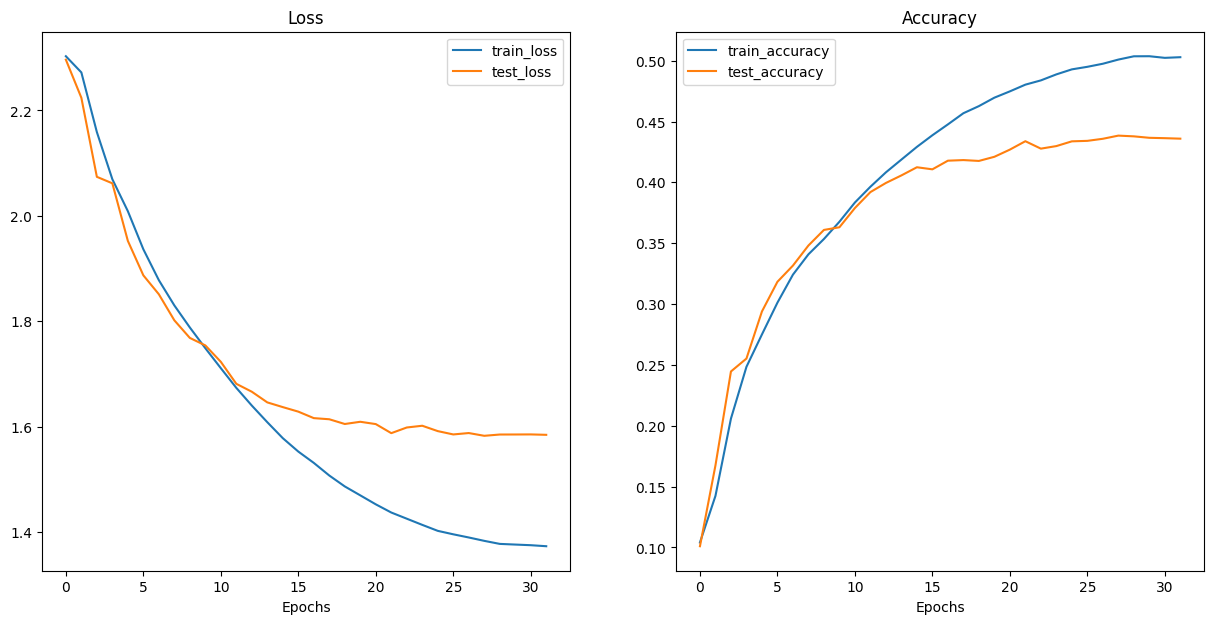

In [ ]:
plt.figure(figsize=(15, 7))

epochs = range(NUM_EPOCHS)

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="train_loss")
plt.plot(epochs, eval_losses, label="test_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="train_accuracy")
plt.plot(epochs, eval_accs, label="test_accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()